In [1]:
# Evaluate by reading metrics from statistical metrics
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt
import re

def parse_metrics_to_dataframe(input_file):
    # Initialize an empty list to store the rows of the DataFrame
    rows = []

    # Define the pattern to extract the date and time
    date_pattern = re.compile(r"\w{3} \d{2} \w{3} \d{4} \d{2}:\d{2}:\d{2} [AP]M \w{3}")

    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Initialize an empty dictionary to store the current block of metrics
    current_block = {}

    # Iterate through the lines in the file
    for line in lines:
        date_match = date_pattern.match(line)
        if date_match:
            if current_block:
                # Append the current block to rows
                rows.append(current_block)
                current_block = {}
            current_block['datetime'] = date_match.group()
        else:
            parts = line.split('\t')
            if len(parts) == 2:
                value, metric = parts
                metric = metric.strip('#').strip()
                current_block[metric] = float(value)
    
    # Append the last block if any
    if current_block:
        rows.append(current_block)
    
    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(rows)
    
    return df


# Load metrics

In [2]:
df_calib_kge = []

for i in range(0, 627, 5):
    inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_kge/'
    infile = f'{inpath}/level1_{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt'
    df_calib_kge.append(parse_metrics_to_dataframe(infile))

trials = [len(i) for i in df_calib_kge]
print('Mean trial number for each basin:', np.mean(trials))

Mean trial number for each basin: 42.84126984126984


In [3]:
df_calib_m2err = []
for i in range(0, 627, 5):
    inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err/'
    infile = f'{inpath}/level1_{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt'
    df_calib_m2err.append(parse_metrics_to_dataframe(infile))

trials = [len(i) for i in df_calib_m2err]
print('Mean trial number for each basin:', np.mean(trials))

Mean trial number for each basin: 77.69047619047619


In [4]:
df_calib_m2err_sr = []
for i in range(0, 627, 5):
    inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err_smallrange/'
    infile = f'{inpath}/level1_{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt'
    df_calib_m2err_sr.append(parse_metrics_to_dataframe(infile))

trials = [len(i) for i in df_calib_m2err_sr]
print('Mean trial number for each basin:', np.mean(trials))

Mean trial number for each basin: 41.817460317460316


In [5]:
tarmetrics = ['streamflow_KGE', 'streamflow_RMSE', 'streamflow_abserr', 'streamflow_maxmontherr', 'streamflow_mean2err']

In [6]:
# For KGE calibration, best metrics
calib_kge_metrics = np.zeros([len(df_calib_kge), 5])
for i in range(len(df_calib_kge)):
    dfi = df_calib_kge[i]
    indi = np.argmax(dfi['streamflow_KGE'].values)
    for j in range(len(tarmetrics)):
        calib_kge_metrics[i, j] = dfi.iloc[indi][tarmetrics[j]]

print('mean', np.nanmean(calib_kge_metrics,axis=0))
print('median', np.nanmedian(calib_kge_metrics,axis=0))

mean [ 0.38216109 11.9164634   5.83074567  7.73250804  6.78162688]
median [0.4510715 6.1617855 2.5660255 2.6246555 2.7678035]


In [6]:
# For m2err calibration, best metrics
calib_m2err_metrics = np.zeros([len(df_calib_m2err), 5])
for i in range(len(df_calib_m2err)):
    dfi = df_calib_m2err[i]
    indi = np.argmin(dfi['streamflow_mean2err'].values)
    for j in range(len(tarmetrics)):
        calib_m2err_metrics[i, j] = dfi.iloc[indi][tarmetrics[j]]

print('mean', np.nanmean(calib_m2err_metrics,axis=0))
print('median', np.nanmedian(calib_m2err_metrics,axis=0))

mean [ 0.26910215 11.49214096  5.3653099   4.50898169  4.93714583]
median [0.3642045 5.896228  2.5794815 1.470698  2.0821935]


In [8]:
# For m2err_sr calibration, best metrics
calib_m2err_metrics_sr = np.zeros([len(df_calib_m2err_sr), 5])
for i in range(len(df_calib_m2err_sr)):
    dfi = df_calib_m2err_sr[i]
    indi = np.argmin(dfi['streamflow_mean2err'].values)
    for j in range(len(tarmetrics)):
        calib_m2err_metrics_sr[i, j] = dfi.iloc[indi][tarmetrics[j]]

print('mean', np.nanmean(calib_m2err_metrics_sr,axis=0))
print('median', np.nanmedian(calib_m2err_metrics_sr,axis=0))

mean [ 0.22753294 12.35378995  5.83928863  6.26876479  6.05402676]
median [0.319966  5.7585255 2.395989  1.7636445 2.20805  ]


# Compare objective functions: kge vs m2err

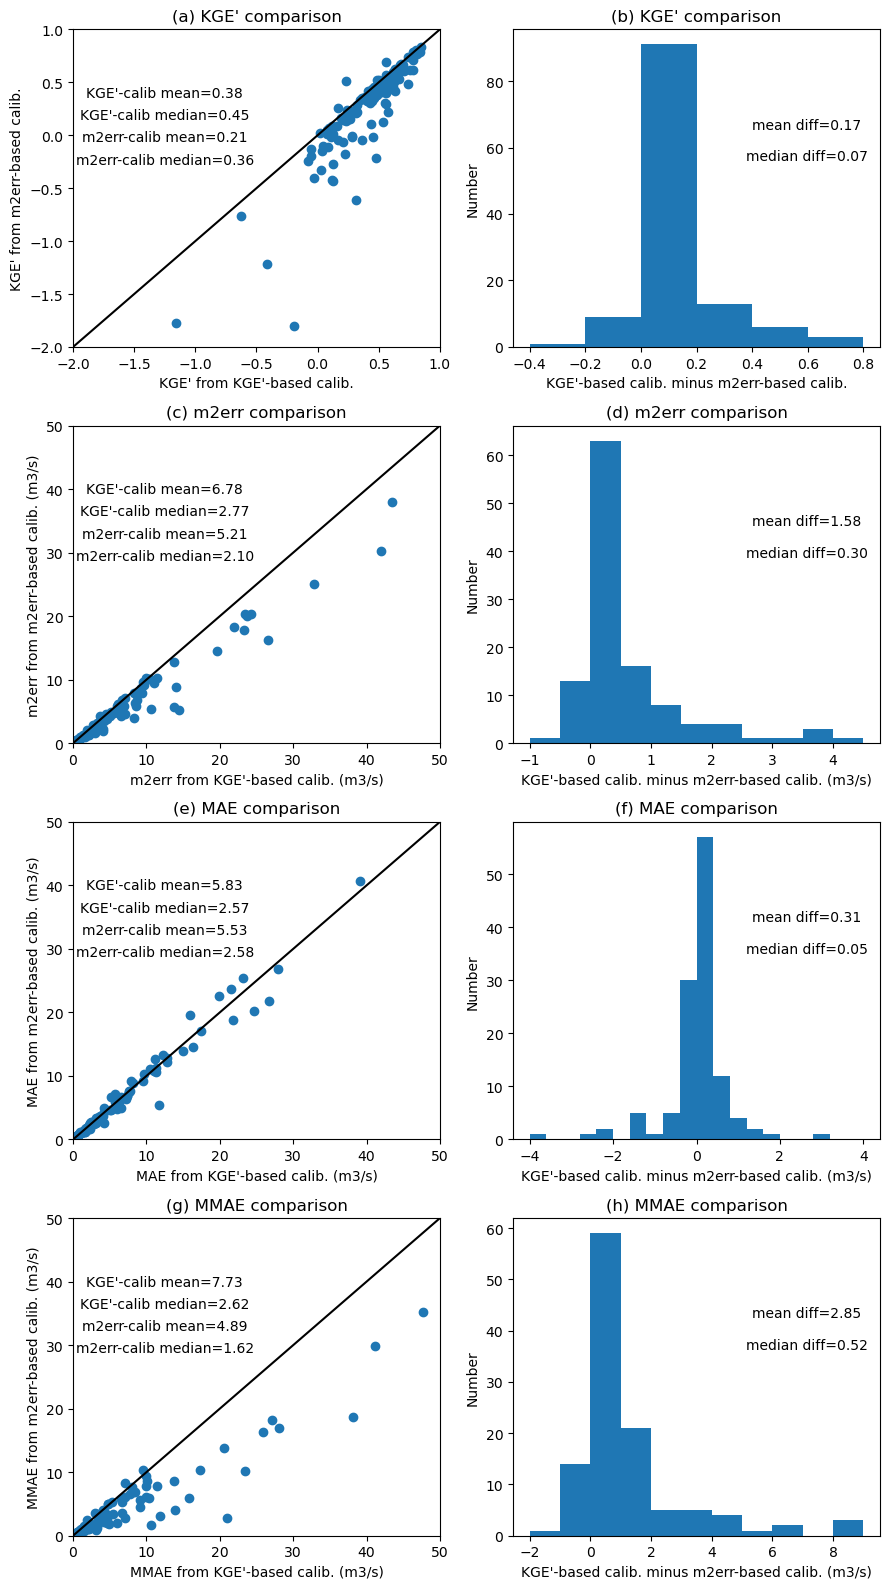

In [10]:
# plot to compare the two objective functions

fig = plt.figure(figsize=[9, 16])

ax = fig.add_subplot(4,2,1)
plt.scatter(calib_kge_metrics[:,0], calib_m2err_metrics[:,0])
t1, t2 = np.nanmean(calib_kge_metrics[:,0]), np.nanmedian(calib_kge_metrics[:,0])
plt.text(0.25, 0.8, f"KGE'-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f"KGE'-calib median={t2:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,0]), np.nanmedian(calib_m2err_metrics[:,0])
plt.text(0.25, 0.66, f"m2err-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'm2err-calib median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([-2, 1], [-2, 1], 'k')
plt.xlabel("KGE' from KGE'-based calib.")
plt.ylabel("KGE' from m2err-based calib.")
plt.xlim([-2, 1])
plt.ylim([-2, 1])
plt.title("(a) KGE' comparison")

ax = fig.add_subplot(4,2,2)
plt.hist(calib_kge_metrics[:,0] - calib_m2err_metrics[:,0], np.arange(-0.4, 1, 0.2))
t = np.nanmean(calib_kge_metrics[:,0] - calib_m2err_metrics[:,0])
plt.text(0.8, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_kge_metrics[:,0] - calib_m2err_metrics[:,0])
plt.text(0.8, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("KGE'-based calib. minus m2err-based calib.")
plt.ylabel('Number')
plt.title("(b) KGE' comparison")

ax = fig.add_subplot(4,2,3)
plt.scatter(calib_kge_metrics[:,4], calib_m2err_metrics[:,4])
t1, t2 = np.nanmean(calib_kge_metrics[:,4]), np.nanmedian(calib_kge_metrics[:,4])
plt.text(0.25, 0.8, f"KGE'-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f"KGE'-calib median={t2:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,4]), np.nanmedian(calib_m2err_metrics[:,4])
plt.text(0.25, 0.66, f"m2err-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'm2err-calib median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("m2err from KGE'-based calib. (m3/s)")
plt.ylabel("m2err from m2err-based calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(c) m2err comparison")

ax = fig.add_subplot(4,2,4)
plt.hist(calib_kge_metrics[:,4] - calib_m2err_metrics[:,4], np.arange(-1, 5, 0.5))
t = np.nanmean(calib_kge_metrics[:,4] - calib_m2err_metrics[:,4])
plt.text(0.8, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_kge_metrics[:,4] - calib_m2err_metrics[:,4])
plt.text(0.8, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("KGE'-based calib. minus m2err-based calib. (m3/s)")
plt.ylabel('Number')
plt.title("(d) m2err comparison")

ax = fig.add_subplot(4,2,5)
plt.scatter(calib_kge_metrics[:,2], calib_m2err_metrics[:,2])
t1, t2 = np.nanmean(calib_kge_metrics[:,2]), np.nanmedian(calib_kge_metrics[:,2])
plt.text(0.25, 0.8, f"KGE'-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f"KGE'-calib median={t2:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,2]), np.nanmedian(calib_m2err_metrics[:,2])
plt.text(0.25, 0.66, f"m2err-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'm2err-calib median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("MAE from KGE'-based calib. (m3/s)")
plt.ylabel("MAE from m2err-based calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(e) MAE comparison")

ax = fig.add_subplot(4,2,6)
plt.hist(calib_kge_metrics[:,2] - calib_m2err_metrics[:,2], np.arange(-4, 4.4, 0.4))
t = np.nanmean(calib_kge_metrics[:,2] - calib_m2err_metrics[:,2])
plt.text(0.8, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_kge_metrics[:,2] - calib_m2err_metrics[:,2])
plt.text(0.8, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("KGE'-based calib. minus m2err-based calib. (m3/s)")
plt.ylabel('Number')
plt.title("(f) MAE comparison")

ax = fig.add_subplot(4,2,7)
plt.scatter(calib_kge_metrics[:,3], calib_m2err_metrics[:,3])
t1, t2 = np.nanmean(calib_kge_metrics[:,3]), np.nanmedian(calib_kge_metrics[:,3])
plt.text(0.25, 0.8, f"KGE'-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f"KGE'-calib median={t2:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,3]), np.nanmedian(calib_m2err_metrics[:,3])
plt.text(0.25, 0.66, f"m2err-calib mean={t1:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'm2err-calib median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("MMAE from KGE'-based calib. (m3/s)")
plt.ylabel("MMAE from m2err-based calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(g) MMAE comparison")

ax = fig.add_subplot(4,2,8)
plt.hist(calib_kge_metrics[:,3] - calib_m2err_metrics[:,3], np.arange(-2, 10, 1))
t = np.nanmean(calib_kge_metrics[:,3] - calib_m2err_metrics[:,3])
plt.text(0.8, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_kge_metrics[:,3] - calib_m2err_metrics[:,3])
plt.text(0.8, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("KGE'-based calib. minus m2err-based calib. (m3/s)")
plt.ylabel('Number')
plt.title("(h) MMAE comparison")

plt.tight_layout()
# plt.savefig('compare_2_objfuncs.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Compare small range calib and big range calib
Big range calib has larger range (upper/lower bound) for some parameters (not all because some parameters already have large range

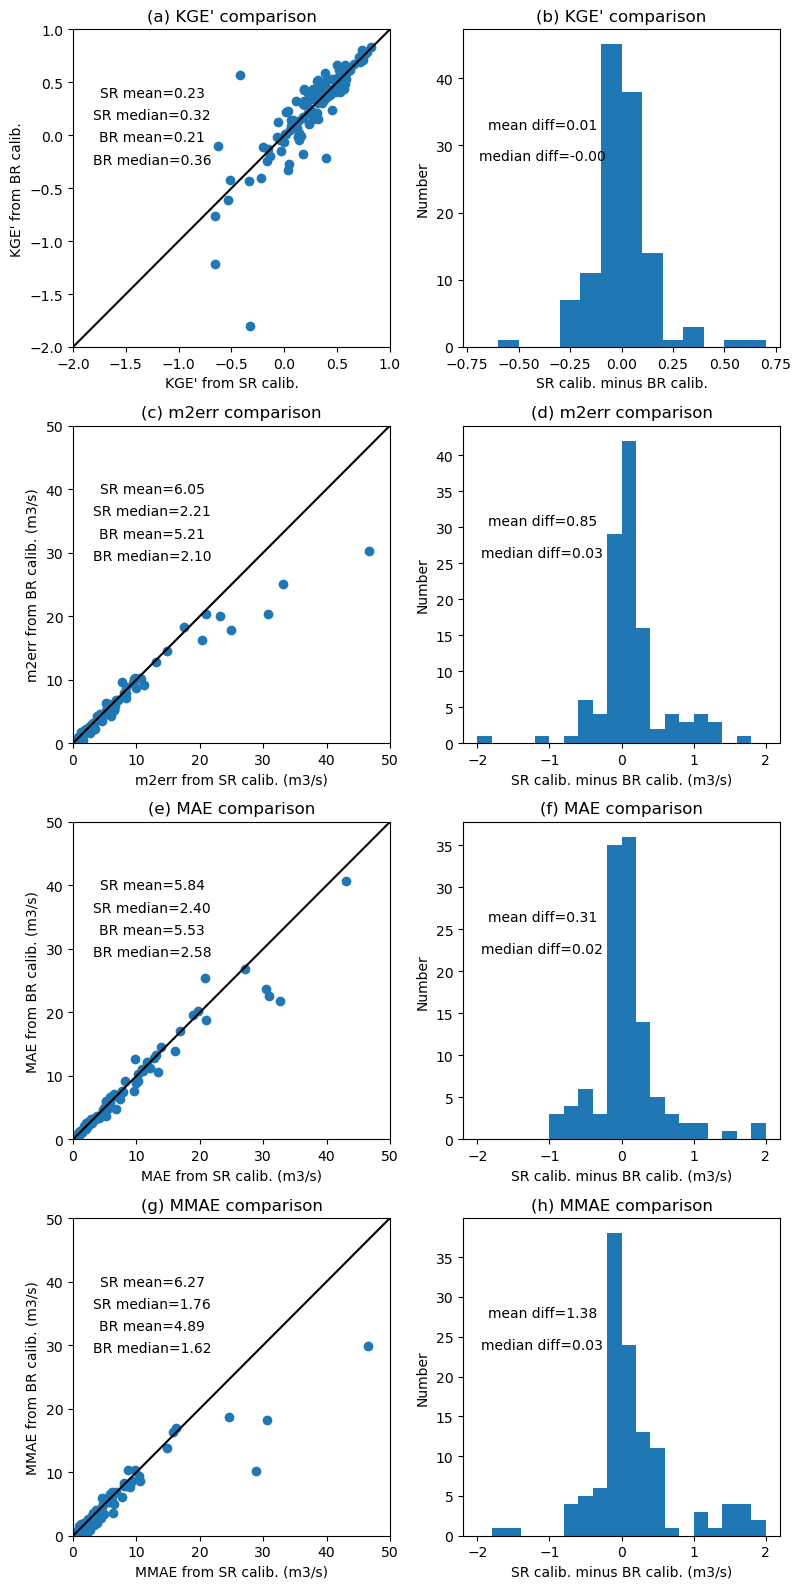

In [22]:
# plot to compare the two objective functions

fig = plt.figure(figsize=[8, 16])

ax = fig.add_subplot(4,2,1)
plt.scatter(calib_m2err_metrics_sr[:,0], calib_m2err_metrics[:,0])
t1, t2 = np.nanmean(calib_m2err_metrics_sr[:,0]), np.nanmedian(calib_m2err_metrics_sr[:,0])
plt.text(0.25, 0.8, f'SR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f'SR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,0]), np.nanmedian(calib_m2err_metrics[:,0])
plt.text(0.25, 0.66, f'BR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'BR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([-2, 1], [-2, 1], 'k')
plt.xlabel("KGE' from SR calib.")
plt.ylabel("KGE' from BR calib.")
plt.xlim([-2, 1])
plt.ylim([-2, 1])
plt.title("(a) KGE' comparison")

ax = fig.add_subplot(4,2,2)
plt.hist(calib_m2err_metrics_sr[:,0] - calib_m2err_metrics[:,0], np.arange(-0.7, 0.8, 0.1))
t = np.nanmean(calib_m2err_metrics_sr[:,0] - calib_m2err_metrics[:,0])
plt.text(0.25, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_m2err_metrics_sr[:,0] - calib_m2err_metrics[:,0])
plt.text(0.25, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("SR calib. minus BR calib.")
plt.ylabel('Number')
plt.title("(b) KGE' comparison")


ax = fig.add_subplot(4,2,3)
plt.scatter(calib_m2err_metrics_sr[:,4], calib_m2err_metrics[:,4])
t1, t2 = np.nanmean(calib_m2err_metrics_sr[:,4]), np.nanmedian(calib_m2err_metrics_sr[:,4])
plt.text(0.25, 0.8, f'SR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f'SR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,4]), np.nanmedian(calib_m2err_metrics[:,4])
plt.text(0.25, 0.66, f'BR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'BR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("m2err from SR calib. (m3/s)")
plt.ylabel("m2err from BR calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(c) m2err comparison")

ax = fig.add_subplot(4,2,4)
plt.hist(calib_m2err_metrics_sr[:,4] - calib_m2err_metrics[:,4], np.arange(-2, 2.2, 0.2))
t = np.nanmean(calib_m2err_metrics_sr[:,4] - calib_m2err_metrics[:,4])
plt.text(0.25, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_m2err_metrics_sr[:,4] - calib_m2err_metrics[:,4])
plt.text(0.25, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("SR calib. minus BR calib. (m3/s)")
plt.ylabel('Number')
plt.title("(d) m2err comparison")


ax = fig.add_subplot(4,2,5)
plt.scatter(calib_m2err_metrics_sr[:,2], calib_m2err_metrics[:,2])
t1, t2 = np.nanmean(calib_m2err_metrics_sr[:,2]), np.nanmedian(calib_m2err_metrics_sr[:,2])
plt.text(0.25, 0.8, f'SR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f'SR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,2]), np.nanmedian(calib_m2err_metrics[:,2])
plt.text(0.25, 0.66, f'BR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'BR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("MAE from SR calib. (m3/s)")
plt.ylabel("MAE from BR calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(e) MAE comparison")

ax = fig.add_subplot(4,2,6)
plt.hist(calib_m2err_metrics_sr[:,2] - calib_m2err_metrics[:,2], np.arange(-2, 2.2, 0.2))
t = np.nanmean(calib_m2err_metrics_sr[:,2] - calib_m2err_metrics[:,2])
plt.text(0.25, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_m2err_metrics_sr[:,2] - calib_m2err_metrics[:,2])
plt.text(0.25, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("SR calib. minus BR calib. (m3/s)")
plt.ylabel('Number')
plt.title("(f) MAE comparison")


ax = fig.add_subplot(4,2,7)
plt.scatter(calib_m2err_metrics_sr[:,3], calib_m2err_metrics[:,3])
t1, t2 = np.nanmean(calib_m2err_metrics_sr[:,3]), np.nanmedian(calib_m2err_metrics_sr[:,3])
plt.text(0.25, 0.8, f'SR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.73, f'SR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t1, t2 = np.nanmean(calib_m2err_metrics[:,3]), np.nanmedian(calib_m2err_metrics[:,3])
plt.text(0.25, 0.66, f'BR mean={t1:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.text(0.25, 0.59, f'BR median={t2:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.plot([0, 50], [0, 50], 'k')
plt.xlabel("MMAE from SR calib. (m3/s)")
plt.ylabel("MMAE from BR calib. (m3/s)")
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.title("(g) MMAE comparison")

ax = fig.add_subplot(4,2,8)
plt.hist(calib_m2err_metrics_sr[:,3] - calib_m2err_metrics[:,3], np.arange(-2, 2.2, 0.2))
t = np.nanmean(calib_m2err_metrics_sr[:,3] - calib_m2err_metrics[:,3])
plt.text(0.25, 0.7, f'mean diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
t = np.nanmedian(calib_m2err_metrics_sr[:,3] - calib_m2err_metrics[:,3])
plt.text(0.25, 0.6, f'median diff={t:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.xlabel("SR calib. minus BR calib. (m3/s)")
plt.ylabel('Number')
plt.title("(h) MMAE comparison")

plt.tight_layout()
plt.savefig('compare_bigPrange_smallPrange_calib.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()